In [1]:
import sys
sys.path.insert(0, '/home/work/Simulation/G2/G2Ana/SRKAnalysis')
import srkdata 
import srkmisc 
import srkmultiprocessing 
import srkanalysis 
import sqlite3 
import numpy as np 
from datetime import date 
import time 
import srkglobal
import srkplotting as spl
import numpy as np
from scipy.optimize import curve_fit

Welcome to JupyROOT 6.12/06


In [2]:
##function definitions
def __multipole_y(order, skew, strength, x_pos, y_pos):
    """Returns the y-component of a B-field given multipole parameters
    and position.
    """
    # Takes a multipole strength A normalized to 4.5 cm
    r_pos = np.sqrt(x_pos**2 + y_pos**2)
    theta = np.arctan2(y_pos, x_pos)
    if skew == 0:
        b_magnitude = strength * r_pos**order * np.cos(order*theta)
    if skew == 1:
        b_magnitude = strength * r_pos**order * np.sin(order*theta)
    return b_magnitude

TR_X = np.array([0]
                + [0.0175 * np.sin(2*np.pi/4*i)
                   for i in np.arange(4)]
                + [0.035 * np.sin(2*np.pi/12*i)
                   for i in np.arange(12)])
TR_X[np.abs(TR_X) < 1.0e-12] = 0
TR_Y = np.array([0]
                + [-0.0175 * np.cos(2*np.pi/4*i)
                   for i in np.arange(4)]
                + [-0.035 * np.cos(2*np.pi/12*i)
                   for i in np.arange(12)])
TR_Y[np.abs(TR_Y) < 1.0e-12] = 0

def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def find_lower_idx(array, value):
    idx = find_nearest_idx(array, value)
    if array[idx] - value <= 0: return idx
    else: return idx-1
    
def find_upper_idx(array, value):
    idx = find_nearest_idx(array, value)
    if array[idx] - value <= 0: return idx + 1
    else: return idx
    
#interpolate to evenly spaced phi
def interpolate(data, n):
    #needs data ordered ascending
    step = 360./n
    data_interpol = np.zeros((n,data.shape[1]))
    
    for i in range(n):
        lb = i*step
        ub = (i+1)*step
        x = (i+0.5)*step
        data_interpol[i,0] = x
        
        h = find_lower_idx(data[:,0], lb)
        j = find_upper_idx(data[:,0], ub)
        
        sum_w = 0.
        for k in range(h,j+1):
            if k >= data.shape[0]: k -= data.shape[0]
            if data[k,0] == x: 
                data_interpol[i,1:] = data[k,1:]
                sum_w = 1.
                break
            else:
                if np.abs(data[k,0]-x)>10*step: w = 1/(360.-np.abs(data[k,0]-x))
                else: w = np.abs(1/(data[k,0]-x))
                data_interpol[i,1:] += data[k,1:]*w
                sum_w += w
        data_interpol[i,1:] = data_interpol[i,1:]/sum_w

    return data_interpol

#Get Fourier coefficients to order n
def get_fourier_coeff(arr, N=None):
    """Calculates the Fourier series coefficients up to order N for
    the array arr, assuming that arr contains one period of data.

    Parameters
    ----------
    arr : the 1D array containing evenly spaced points
    N : the function will return the first 2N + 1 Fourier coeff.

    Returns
    -------
    a0 : float
    a,b : numpy float arrays describing respectively the cosine and sine coeff.
    """

    y = np.fft.rfft(arr) / arr.size
    N = int(N)
    
    if N: N +=1 #because last index is excluded
    #else: N=-1

    y *= 2
    return np.hstack((y[0].real, y[1:N].real, -y[1:N].imag))

#Fourier series to order n
def fourier_series(t, *args):
    #global T
    T=360.
    a0 = args[0]
    a = np.asarray(args[1:(len(args)+1)/2])
    b = np.asarray(args[(len(args)+1)/2:])
    a0 = a0*np.ones(t.size).reshape((t.size, 1))
    #to use matrix multiplication to handle dot product and arrays:
    n = np.arange(1, a.size +1).reshape((a.size, 1))
    t = t.reshape((t.size, 1)).transpose()
    a = a.reshape((a.size, 1)).transpose()
    b = b.reshape((b.size, 1)).transpose()
    
    c = np.cos(2*np.pi*n.dot(t)/T)
    s = np.sin(2*np.pi*n.dot(t)/T)
    f = a0/2 + (a.dot(c)).transpose() + (b.dot(s)).transpose()
    return f.flatten()

def list2str(data):
    #assumes one dimensional array
    s = str(data[0])
    for i in range(len(data)-1):
        s += " "
        s += str(data[i+1])
    return s

def list2strs(data):
    if data.ndim == 1: return list2str(data)
    elif data.ndim == 2: 
        strlist = []
        for i in range(data.shape[1]):
            strlist.append(list2str(data[:,i]))
        return strlist
    else: print "Can't convert array to string(s): wrong dimensions"

def cosinus(t, A, w):
    return A*np.cos(w*t)

theo_ideal = 1.6021766208e-19*0.00116592091*1.4513/1.883531594e-28

def w_a(MdotV, time_arr):
    pars, covs = curve_fit(cosinus, time_arr, MdotV, [1, theo_ideal])
    return (pars[1], covs[1,1])

def ppb(MdotV, time_arr, theo=theo_ideal):
    wa = w_a(MdotV, time_arr)[0]
    return (wa-theo)*1e9/theo

In [3]:
##multipole definitions

# No longer attempt to calculate either 18-pole.
_MULTIPOLE_ORDER = [0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 7, 7] # is acutally n-1
_MULTIPOLE_SKEW = [0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1]
_MULTS = np.array([__multipole_y(_MULTIPOLE_ORDER[i], _MULTIPOLE_SKEW[i], 1, TR_X, TR_Y) for i in range(14)])
_MULTS[np.abs(_MULTS) < 1.0e-9] = 0 

THETA_TR = np.linalg.pinv(_MULTS)
THETA_TR[np.abs(THETA_TR) < 1.0e-9] = 0

#add row of zeros to THETA_TR, then col of (1,0...) to keep column of phi
THETA_TR = np.vstack((np.zeros((1,14)),THETA_TR))
THETA_TR = np.hstack((np.zeros((18,1)),THETA_TR))
THETA_TR[0,0] = 1

#load trolley data - skip time since we're using phi
TR_DATA = np.loadtxt("/home/work/Simulation/Fits/trolley_run_3956.dat", delimiter=',', skiprows=1)[:,1:]
#there are multiples but will be averaged when interpolating
#order ascending
TR_DATA = TR_DATA[TR_DATA[:,0].argsort()]

#interpolate
TR_INT = interpolate(TR_DATA,3600)

#add 61.74MHz, divide by gyromagn. ratio of proton to get T --- 1.4513 T == 61.79 MHz
gamma_p = 42.5774806e6 #Hz/T
f_ref = 61.74e6 #Hz
TR_INT[:,1:] = (TR_INT[:,1:] + f_ref)/gamma_p

TR_MULTS = TR_INT.dot(THETA_TR)
#n by 15, first column is phi

/usr/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


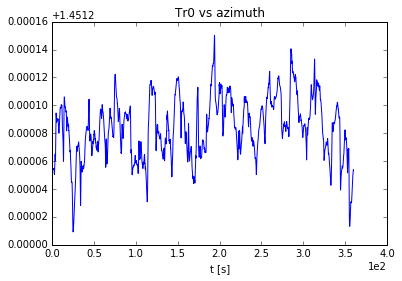

In [4]:
spl.plot_single("Tr0 vs azimuth", TR_INT[:,1],TR_INT[:,0],"show")

In [120]:
##fourier expansion of multipoles
spacing = 0.5#in degrees
B0_str = []
for i in range(3):
    coef_B0 = get_fourier_coeff(TR_MULTS[:,i+1],180/spacing)

#make into string
#B0_str = list2str(coef_B0)
    B0_str.append(list2str(coef_B0))

#spl.plot_single("B0 vs azimuth", fourier_series(TR_INT[:,0],*coef_B0),TR_INT[:,0],"show")
#print coef_B0[0]/2

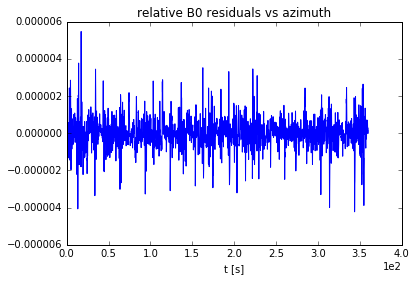

In [6]:
spl.plot_single("relative B0 residuals vs azimuth", (fourier_series(TR_INT[:,0],*coef_B0)-TR_INT[:,1])/1.4513,TR_INT[:,0],"show")

In [7]:
##average of multipoles
AVG_MULTS = np.mean(TR_MULTS,0)[1:]
print AVG_MULTS
AVG_MULTS *= 2
print AVG_MULTS
#for i in range(14):
#    AVG_MULTS[i] *= 0.045**_MULTIPOLE_ORDER[i]
#print AVG_MULTS
AVG_MULTS = AVG_MULTS.tolist()

[  1.45128386e+00  -2.89819752e-07   5.24886150e-06  -8.50863921e-04
   1.97794191e-04  -8.38352389e-05   4.45553998e-03   2.05600366e-02
  -4.87997401e-01  -6.28298915e+00  -1.58687243e+00  -1.96067127e+02
   0.00000000e+00   0.00000000e+00]
[  2.90256772e+00  -5.79639504e-07   1.04977230e-05  -1.70172784e-03
   3.95588383e-04  -1.67670478e-04   8.91107997e-03   4.11200732e-02
  -9.75994802e-01  -1.25659783e+01  -3.17374487e+00  -3.92134254e+02
   0.00000000e+00   0.00000000e+00]


In [8]:
AVG_PR = np.mean(TR_MULTS,0)[1:].dot(_MULTS)
print AVG_PR

[ 1.45128386  1.45128406  1.45128359  1.45128419  1.45128362  1.45128539
  1.45128276  1.45128414  1.45128215  1.45128378  1.45128491  1.4512852
  1.45128356  1.45128407  1.45128283  1.45128274  1.45128479]


In [130]:
start_time = time.time()
today = date.today()

s = srkdata.default_srk_settings("g2")
r = srkdata.default_run_settings("g2")
srkglobal.set_computer("home_laptop")

# SRK settings and run settings
r['Title'] = 'Test'
r['SRKVersion'] = 'develop'
r['Date'] = today.strftime('%m/%d/%y')
r['RunType'] = 'multipoleTests'
r['NumTracks'] = 1
                
                
s['TimeLimit'] = 1e-4
s['RecordPeriodicSteps'] = 1
s['PeriodicStopTime'] = 1e-9
s['UseAltStepping'] = 0
s['ConstStepper'] = 0
s['InitialStepSize'] = 1e-10
s['ManualTracking'] = 1
s['RingRadius'] = 7.112
s['StorageDiameter'] = 0.09
s['RandomSeed'] = 0
s['InitialPos'] = '7.112 0.01 0'
#s['InitialVel'] = '0 647638.576022 299617141.695'
s['Mass'] = 1.883531594e-28
s['GyromagneticRatio'] = 0.00116592091
s['InitialMag'] = '0 0 1'
s['EPSAbs'] = 1e-13
s['EPSRel'] = 1e-11
#s['B0FieldStrength'] = "1.4513"
#s['B0FieldDirection'] = '0 -1 0'
#s['BQuadFieldStrength'] = 0.
#s['EQuadFieldStrength'] = 0.
#s['EQuadFieldStrength'] = 9.6e6
mstr = 1.4513*2
s['BMultiFieldStrength'] = B0_str[:3]#AVG_MULTS#[:7]#B0_str
s['BMultiOrder'] = _MULTIPOLE_ORDER[:3]
s['BMultiSkew'] = _MULTIPOLE_SKEW[:3]
estr = -9.6e6*2
s['EMultiFieldStrength'] = [-19.2e6, 2457.6e6, 58982.4e6] #estr
s['EMultiOrder'] = [1, 3, 5]


#calculate velocity from momentum
p = 1.6537e-18
gamma = np.sqrt(1 + (p/(s['Mass']*299792458.))**2)
v = p/(gamma*s['Mass'])
s['InitialVel'] = '0 0 '+str(v)

In [131]:
srkdata.make_and_run(s,r)

Insert String: INSERT INTO RunLog(ConstStepper,Title,NumTracks,SRKVersion,EPSRel,ManualTracking,Mass,RunType,Run,EPSAbs,RecordPeriodicSteps,InitialPos,UseAltStepping,InitialMag,RandomSeed,EQuadFieldStrength,PeriodicStopTime,GyromagneticRatio,InitialStepSize,TimeLimit,B0FieldDirection,Date,BQuadFieldStrength,B0FieldStrength,InitialVel) Values (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)

Values: 
(0, 'Test', 1, 'develop', 1e-11, 1, 1.883531594e-28, 'multipoleTests', 246, 1e-13, 1, '7.112 0.01 0', 0, '0 0 1', 0, 0.0, 1e-09, 0.00116592091, 1e-10, 0.0001, '0 1 0', '12/16/19', 0.0, 0.0, '0 0 299617841.647')
/home/work/Simulation/G2/G2Out/macros/RID246.mac created.

/home/work/Simulation/G2/G2Sim/Debug/G2Sim /home/work/Simulation/G2/G2Out/macros/RID246.mac > /home/work/Simulation/G2/G2Out/logs/logRID246.txt
Update String: UPDATE RunLog SET ResultsFilePath=?WHERE Run=246

Values: 
('/home/work/Simulation/G2/G2Out/results/Results_RID246.root',)


Info in <TGeoManager::TGeoManager>: Geometry theManager, SRK Simulation Geometry created
Warning in <TVector3::SetMag>: zero vector can't be stretched
Warning in <TVector3::SetMag>: zero vector can't be stretched
Warning in <TVector3::SetMag>: zero vector can't be stretched
Warning in <TVector3::SetMag>: zero vector can't be stretched
Warning in <TVector3::SetMag>: zero vector can't be stretched
Warning in <TVector3::SetMag>: zero vector can't be stretched
Warning in <TVector3::SetMag>: zero vector can't be stretched
Warning in <TVector3::SetMag>: zero vector can't be stretched
Warning in <TVector3::SetMag>: zero vector can't be stretched
Warning in <TVector3::SetMag>: zero vector can't be stretched
Warning in <TVector3::SetMag>: zero vector can't be stretched
Warning in <TVector3::SetMag>: zero vector can't be stretched


In [ ]:
vel = ['0 0 299617841.647', '645701.576421 0 299617841.647', '0 647638.576022 299617141.695']
E = [0, 9.6e6]
for v in vel:
    s['InitialVel'] = v
    for e in E:
        s['EQuadFieldStrength'] = e
        srkdata.make_and_run(s,r)

In [ ]:
srkglobal.set_computer("home_laptop")
srkglobal.set_graphs_dir('/home/work/Simulation/G2/G2Out/graphs/')
#bid = range(99,105)
bid = [172]

for i in bid:
    btree = spl.make_tree_to_array(i)
    ctree = spl.make_tree_to_array(i+23)
    time_arr = spl.make_timeline(i)

    MdotV = btree[10][:-1]
    bsim = w_a(MdotV, time_arr)
    print "Simulated base case: ", bsim[0]
    MdotV = ctree[10][:-1]
    csim = w_a(MdotV, time_arr)
    print "Simulated comparison case: ", csim[0]
    print "Difference (ppb): ", (bsim[0]-csim[0])*1e9/bsim[0], "\n"

In [136]:
srkglobal.set_computer("home_laptop")
srkglobal.set_graphs_dir('/home/work/Simulation/G2/G2Out/graphs/')
bid = 246

tree = spl.make_tree_to_array(bid)
time_arr = spl.make_timeline(bid)

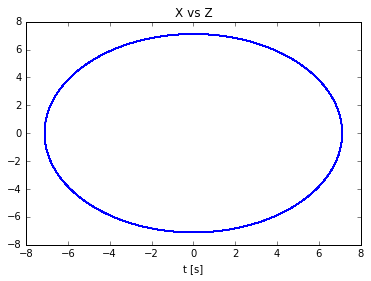

In [137]:
x = tree[0]
y = tree[1]
z = tree[2]

spl.plot_single('X vs Z', z, x, 'show')
#spl.plot_single('X vs t', x[:152], time_arr[:152], 'show')
#T_cyclo = 2*np.pi*7.112/v

In [138]:
MdotV = tree[10]
sim = w_a(MdotV, time_arr)
print "Simulated: ", sim[0]
print "Theoretical: ", theo_ideal
print "ppb: ", ppb(MdotV, time_arr)

Simulated:  1439325.11998
Theoretical:  1439341.23409
ppb:  -11195.4792238


In [139]:
theo_data = 1.6021766208e-19*0.00116592091*AVG_PR[0]/1.883531594e-28
print "Probe 0 avg:", AVG_PR[0]
print "w_a theoretical from that:", theo_data
print "simulated difference in ppb:", ppb(MdotV, time_arr, theo_data)

Probe 0 avg: 1.45128386082
w_a theoretical from that: 1439325.2279
simulated difference in ppb: -74.9823778356


1.45126935083


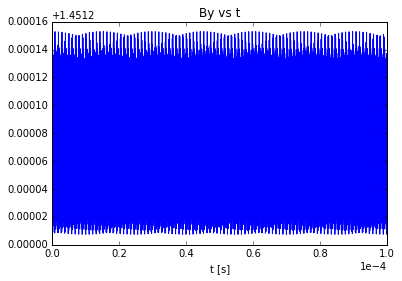

1.45126460758


In [127]:
By = tree[11]
magB = tree[12]
print np.mean(By)
spl.plot_single('By vs t', By[1:], time_arr[1:], 'show')
print By[-1]

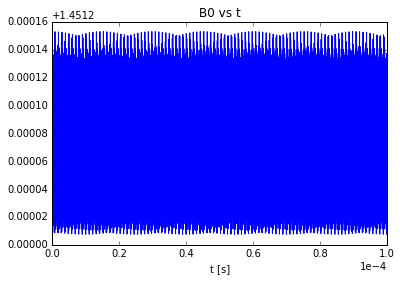

In [23]:
phi = np.arctan2(z,x)*360./(2*np.pi)
#spl.plot_single("B0 vs t", fourier_series(time_arr*360./T_cyclo,*coef_B0),time_arr,"show")
spl.plot_single("B0 vs t", fourier_series(phi,*coef_B0),time_arr,"show")

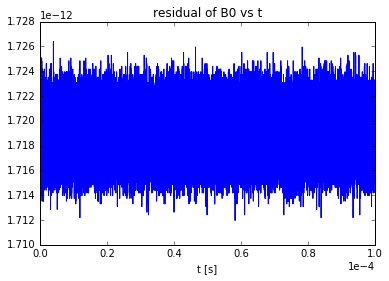

1.1895652187e-12


In [24]:
spl.plot_single("residual of B0 vs t", fourier_series(phi[1:],*coef_B0)-By[1:],time_arr[1:],"show")
#max relative residual
print np.max(np.abs(fourier_series(phi[1:],*coef_B0)-By[1:]))/AVG_PR[0]

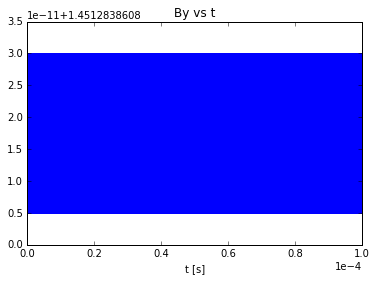

In [32]:
#simulated B_y
spl.plot_single('By vs t', By[1:152], time_arr[1:152], 'show')

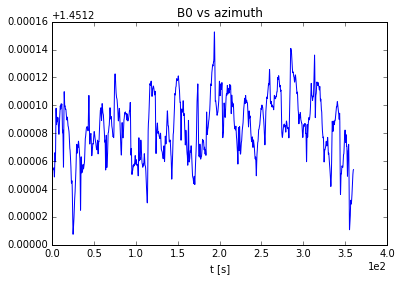

In [183]:
#calculated B_y from Fourier coefficients
spl.plot_single("B0 vs azimuth", fourier_series(TR_INT[:,0],*coef_B0),TR_INT[:,0],"show")

1.45178056742


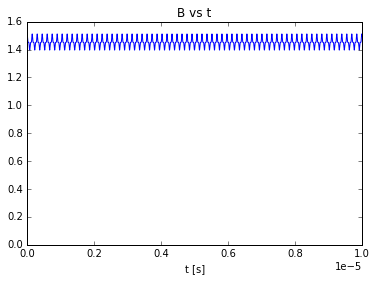

In [56]:
print np.mean(magB)
spl.plot_single('B vs t', magB, time_arr, 'show')

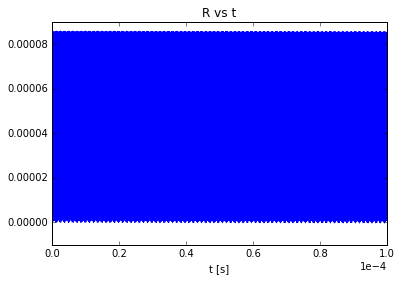

4.29540199942e-05


In [116]:
r = np.sqrt(x**2 + z**2) - 7.112
spl.plot_single('R vs t', r, time_arr, 'show')
print np.mean(r)

(14, 100001)


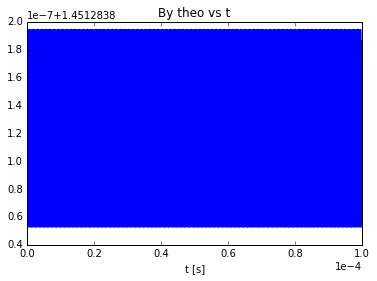

In [117]:
cf_mults = np.array([__multipole_y(_MULTIPOLE_ORDER[i], _MULTIPOLE_SKEW[i], AVG_MULTS[i]/2, r, y) for i in range(14)])
print cf_mults.shape
cf_mults = np.sum(cf_mults, 0)
#print cf_mults.shape
#print cf_mults[:,:10].transpose()
spl.plot_single('By theo vs t', cf_mults, time_arr, 'show')

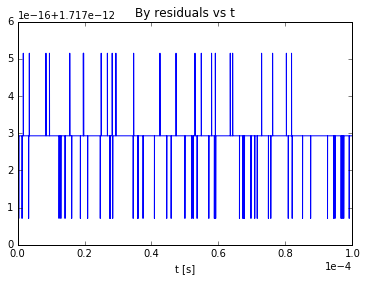

In [118]:
spl.plot_single('By residuals vs t', cf_mults[1:]-By[1:], time_arr[1:], 'show')

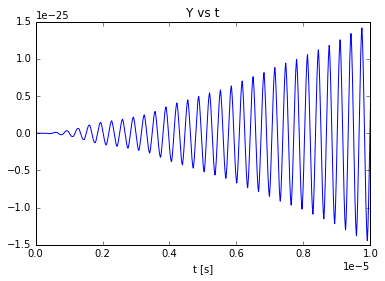

-6.777810791e-28


In [24]:
spl.plot_single('Y vs t', y, time_arr, 'show')
print np.mean(y)

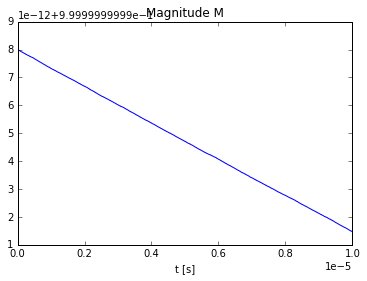

1.0


In [41]:
magM = tree[9]
spl.plot_single('Magnitude M', magM, time_arr, 'show')
print magM[1]

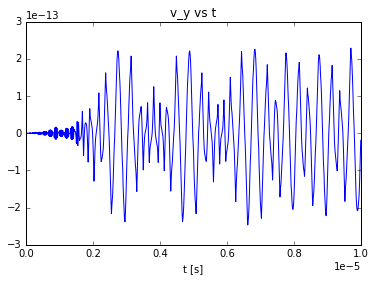

In [34]:
vx = tree[3]
vy = tree[4]
vz = tree[5]

spl.plot_single('v_y vs t', vy, time_arr, 'show')

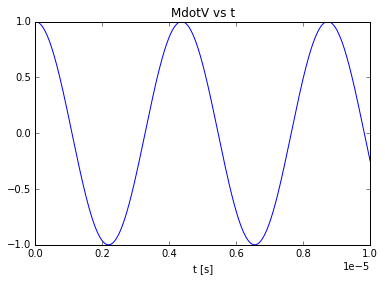

In [94]:
Mv = tree[10][:-1]

spl.plot_single('MdotV vs t', Mv, time_arr, 'show')

In [ ]:
# test B0, E quad with y, x osci to check corrections
# add B to branch and write out tree, cf python generated fourier series times position?